In [1]:
# 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



#Loading the Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pickle
import re, string
%matplotlib notebook

In [3]:
# log data 불러오기
df = pd.read_table("/content/drive/MyDrive/Colab Notebooks/fake_log/data/http-20220221204507.log", 
                   delimiter=" ",header=None,names=["IP", "user_identifier","user_name","Time","URL","Status","Byte"])
df.head(10)

,IP,user_identifier,user_name,Time,URL,Status,Byte
0,191.219.79.103,user-identifier,nona,[21/Feb/2022:20:46:47],GET https://learningcatalytics.com:443/questio...,200,5019
1,205.168.133.20,user-identifier,nona,[21/Feb/2022:20:50:02],GET https://learningcatalytics.com:443/search/...,200,4999
2,178.30.221.218,user-identifier,kirana,[21/Feb/2022:20:53:08],PUT https://learningcatalytics.com:443/search/...,200,4950
3,149.143.48.252,user-identifier,kirana,[21/Feb/2022:20:55:15],PUT https://learningcatalytics.com:443/posts/p...,200,4950
4,90.71.182.91,user-identifier,nona,[21/Feb/2022:20:57:55],GET https://learningcatalytics.com:443/explore...,504,5096
5,6.21.146.150,user-identifier,asuna,[21/Feb/2022:20:59:38],GET https://learningcatalytics.com:443/search/...,504,5060
6,55.243.33.243,user-identifier,kirana,[21/Feb/2022:21:01:43],PUT https://learningcatalytics.com:443/posts/p...,200,5051
7,207.240.15.38,user-identifier,mara,[21/Feb/2022:21:06:08],GET https://learningcatalytics.com:443/list HT...,200,5033
8,172.61.203.148,user-identifier,asuna,[21/Feb/2022:21:09:13],PUT https://learningcatalytics.com:443courses/...,504,5086
9,48.61.59.216,user-identifier,asuna,[21/Feb/2022:21:09:54],GET https://learningcatalytics.com:443/posts/p...,504,5048


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   IP               10000 non-null  object
 1   user_identifier  10000 non-null  object
 2   user_name        10000 non-null  object
 3   Time             10000 non-null  object
 4   URL              10000 non-null  object
 5   Status           10000 non-null  int64 
 6   Byte             10000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


#EDA

In [5]:
# URL 확인
df['URL'][0]

'GET https://learningcatalytics.com:443/questions/856776/item_versions HTTP/1.0'

In [6]:
df[df['URL']=="GET https://learningcatalytics.com:443/questions/856776/item_versions HTTP/1.0"]

,IP,user_identifier,user_name,Time,URL,Status,Byte
0,191.219.79.103,user-identifier,nona,[21/Feb/2022:20:46:47],GET https://learningcatalytics.com:443/questio...,200,5019
19,189.125.99.244,user-identifier,asuna,[21/Feb/2022:21:35:15],GET https://learningcatalytics.com:443/questio...,200,5019
37,152.67.94.65,user-identifier,mara,[21/Feb/2022:22:28:20],GET https://learningcatalytics.com:443/questio...,200,4917
41,145.59.238.46,user-identifier,asuna,[21/Feb/2022:22:39:56],GET https://learningcatalytics.com:443/questio...,504,4909
75,176.71.10.255,user-identifier,nona,[22/Feb/2022:00:16:48],GET https://learningcatalytics.com:443/questio...,404,5024
...,...,...,...,...,...,...,...
9883,163.218.83.190,user-identifier,nona,[12/Mar/2022:18:49:49],GET https://learningcatalytics.com:443/questio...,200,4993
9892,79.54.199.251,user-identifier,asuna,[12/Mar/2022:19:11:18],GET https://learningcatalytics.com:443/questio...,404,4947
9904,182.115.114.88,user-identifier,asuna,[12/Mar/2022:19:52:19],GET https://learningcatalytics.com:443/questio...,404,5044
9906,132.238.243.149,user-identifier,asuna,[12/Mar/2022:19:58:59],GET https://learningcatalytics.com:443/questio...,200,4973


In [7]:
cnt = 0
for url in df['URL']:
  if url.endswith('HTTP/1.0'):
    cnt += 1
print(cnt) 

10000


In [8]:
df['user_identifier'].value_counts()

user-identifier    10000
Name: user_identifier, dtype: int64

#발견한 점
- 동일한 url을 갖는 log data가 748개 있다.
- 모든 url은 HTTP/1.0로 끝난다.
- user_identifier는 모두 동일하다.

#분석 접근 방법
- url에서 HTTP/1.0을 제거, word_tokenize 및 cleaning을 진행한다.
- Status를 object type으로 변경한다.
- user_name + url + Status 형태의 데이터로 만든다.
- Vectorization 진행한다.
- PCA로 차원축소한다.
- 클러스터링을 진행한다.
- 각 클러스터터에 많이 들어간 문자를 찾는다.
- 2차원 평면에 시각화를 진행한다.

#Data Preprocessing

In [9]:
def clean_text(text):
    
    PUNCTUATION = """!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""    

    text = " ".join([c for c in text if c not in PUNCTUATION])
    
    text = re.sub(r"/"," ",text)
    return text

In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
from nltk.tokenize import word_tokenize

# HTTP/1.0을 제거
df['tmp']=df['URL'].map(lambda x: x.rstrip('HTTP/1.0'))
# word_tokenize
df['tmp'] = df['tmp'].apply(word_tokenize)
# cleaning
df['text'] = df['tmp'].apply(clean_text)
df['text'] = df['text'].str.replace('.',' ')
df['text'] = df['text'].str.replace(':',' ')
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if __name__ == '__main__':


,IP,user_identifier,user_name,Time,URL,Status,Byte,tmp,text
0,191.219.79.103,user-identifier,nona,[21/Feb/2022:20:46:47],GET https://learningcatalytics.com:443/questio...,200,5019,"[GET, https, :, //learningcatalytics.com:443/q...",GET https learningcatalytics com 443 questio...
1,205.168.133.20,user-identifier,nona,[21/Feb/2022:20:50:02],GET https://learningcatalytics.com:443/search/...,200,4999,"[GET, https, :, //learningcatalytics.com:443/s...",GET https learningcatalytics com 443 search ...
2,178.30.221.218,user-identifier,kirana,[21/Feb/2022:20:53:08],PUT https://learningcatalytics.com:443/search/...,200,4950,"[PUT, https, :, //learningcatalytics.com:443/s...",PUT https learningcatalytics com 443 search ...
3,149.143.48.252,user-identifier,kirana,[21/Feb/2022:20:55:15],PUT https://learningcatalytics.com:443/posts/p...,200,4950,"[PUT, https, :, //learningcatalytics.com:443/p...",PUT https learningcatalytics com 443 posts p...
4,90.71.182.91,user-identifier,nona,[21/Feb/2022:20:57:55],GET https://learningcatalytics.com:443/explore...,504,5096,"[GET, https, :, //learningcatalytics.com:443/e...",GET https learningcatalytics com 443 explore


In [12]:
# Status를 obj type으로 변경.
df['Status'] = df['Status'].map(lambda x: str(x))

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   IP               10000 non-null  object
 1   user_identifier  10000 non-null  object
 2   user_name        10000 non-null  object
 3   Time             10000 non-null  object
 4   URL              10000 non-null  object
 5   Status           10000 non-null  object
 6   Byte             10000 non-null  int64 
 7   tmp              10000 non-null  object
 8   text             10000 non-null  object
dtypes: int64(1), object(8)
memory usage: 703.2+ KB


In [14]:
df['processed_text'] = df['user_name']+" "+df['text']+" "+df['Status']
df.head()

,IP,user_identifier,user_name,Time,URL,Status,Byte,tmp,text,processed_text
0,191.219.79.103,user-identifier,nona,[21/Feb/2022:20:46:47],GET https://learningcatalytics.com:443/questio...,200,5019,"[GET, https, :, //learningcatalytics.com:443/q...",GET https learningcatalytics com 443 questio...,nona GET https learningcatalytics com 443 qu...
1,205.168.133.20,user-identifier,nona,[21/Feb/2022:20:50:02],GET https://learningcatalytics.com:443/search/...,200,4999,"[GET, https, :, //learningcatalytics.com:443/s...",GET https learningcatalytics com 443 search ...,nona GET https learningcatalytics com 443 se...
2,178.30.221.218,user-identifier,kirana,[21/Feb/2022:20:53:08],PUT https://learningcatalytics.com:443/search/...,200,4950,"[PUT, https, :, //learningcatalytics.com:443/s...",PUT https learningcatalytics com 443 search ...,kirana PUT https learningcatalytics com 443 ...
3,149.143.48.252,user-identifier,kirana,[21/Feb/2022:20:55:15],PUT https://learningcatalytics.com:443/posts/p...,200,4950,"[PUT, https, :, //learningcatalytics.com:443/p...",PUT https learningcatalytics com 443 posts p...,kirana PUT https learningcatalytics com 443 ...
4,90.71.182.91,user-identifier,nona,[21/Feb/2022:20:57:55],GET https://learningcatalytics.com:443/explore...,504,5096,"[GET, https, :, //learningcatalytics.com:443/e...",GET https learningcatalytics com 443 explore,nona GET https learningcatalytics com 443 ex...


In [15]:
len(df[df['processed_text']=='nona GET https   learningcatalytics com 443 questions 856776 item_versions 200'])

93

In [16]:
# 중복 제거
df = df.drop_duplicates(['processed_text'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 0 to 9916
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   IP               520 non-null    object
 1   user_identifier  520 non-null    object
 2   user_name        520 non-null    object
 3   Time             520 non-null    object
 4   URL              520 non-null    object
 5   Status           520 non-null    object
 6   Byte             520 non-null    int64 
 7   tmp              520 non-null    object
 8   text             520 non-null    object
 9   processed_text   520 non-null    object
dtypes: int64(1), object(9)
memory usage: 44.7+ KB


#Vectorization

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [18]:
text = df['processed_text'].values
max_features = 2**12

X = vectorize(text, max_features)

In [19]:
X.toarray()

array([[0.34280687, 0.        , 0.        , ..., 0.43654034, 0.        ,
        0.        ],
       [0.35790864, 0.        , 0.        , ..., 0.        , 0.45137749,
        0.45137749],
       [0.35268333, 0.        , 0.        , ..., 0.        , 0.44478758,
        0.44478758],
       ...,
       [0.        , 0.37334033, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.38156354, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.50094824, ..., 0.        , 0.        ,
        0.        ]])

In [20]:
#정규화
X_norm = normalize(X, norm='l1', axis=1)
X_norm.toarray()

array([[0.11731042, 0.        , 0.        , ..., 0.14938654, 0.        ,
        0.        ],
       [0.12170167, 0.        , 0.        , ..., 0.        , 0.1534844 ,
        0.1534844 ],
       [0.11996162, 0.        , 0.        , ..., 0.        , 0.15128993,
        0.15128993],
       ...,
       [0.        , 0.13236336, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.13461138, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.19078759, ..., 0.        , 0.        ,
        0.        ]])

#PCA & Clustering

In [21]:
# PCA 이전 피처 수
len(X_norm.toarray()[0])

31

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X_norm.toarray())
X_reduced

array([[-0.01221647,  0.09768648,  0.22128876, ..., -0.03344128,
         0.02158512, -0.06847021],
       [-0.02215584,  0.16799244, -0.12287033, ..., -0.02588373,
        -0.01455432, -0.10507703],
       [-0.02387078,  0.17011861, -0.12048069, ..., -0.02716591,
        -0.04982119, -0.04157141],
       ...,
       [ 0.17463786, -0.06272662, -0.01713633, ..., -0.09754757,
        -0.07142546,  0.09467215],
       [ 0.18368201, -0.06730283, -0.01235289, ...,  0.08026124,
        -0.00067476,  0.02226524],
       [-0.0185446 ,  0.10792785, -0.05957584, ...,  0.01809445,
         0.01838888,  0.0508784 ]])

In [23]:
# PCA 이후 피처 수
X_reduced.shape

(520, 15)

In [24]:
# K 평균 클러스터링
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [25]:
from sklearn import metrics
from scipy.spatial.distance import cdist 

# run kmeans with many different k
distortions = []
K = range(2, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42)
    k_means.fit(X_reduced)
    # 두 지점 사이의 거리계산
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

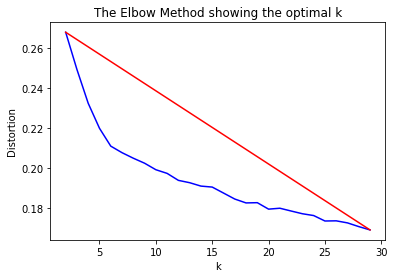

In [26]:
%matplotlib inline
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [59]:
# Run k-means.
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

#Dimensionality Reduction with t-SNE

In [60]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50)  # Changed perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(X_norm.toarray())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 520 samples in 0.001s...
[t-SNE] Computed neighbors for 520 samples in 0.059s...
[t-SNE] Computed conditional probabilities for sample 520 / 520
[t-SNE] Mean sigma: 0.148468
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.680759
[t-SNE] KL divergence after 950 iterations: 0.644198


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


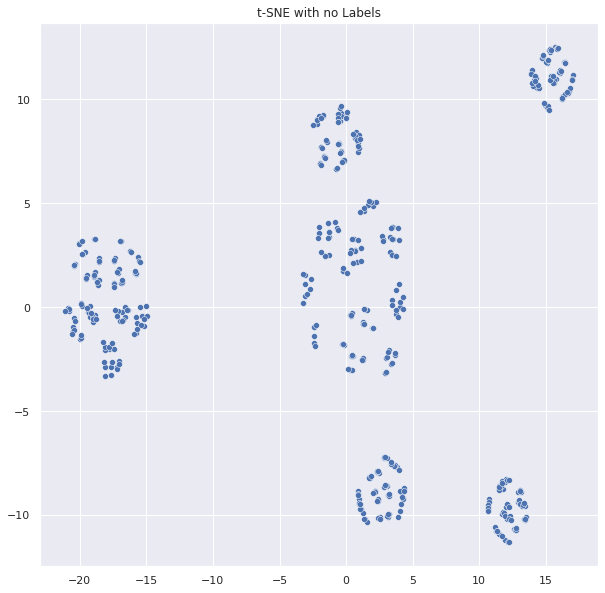

In [61]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(10,10)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
# plt.savefig("t-sne_covid19.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


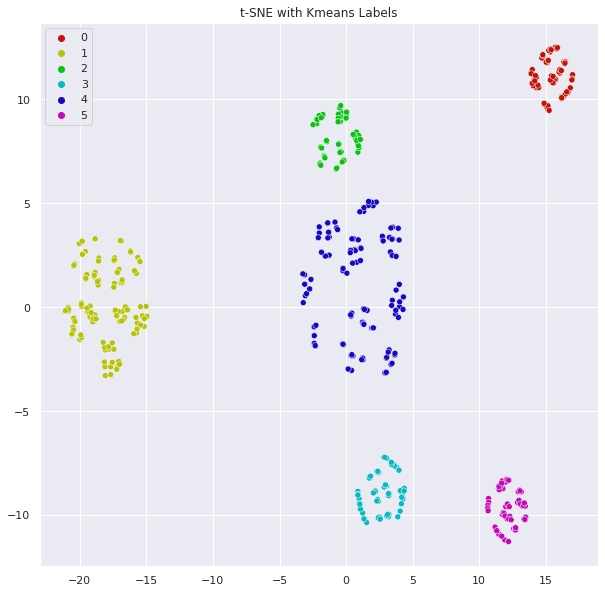

In [63]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(10,10)})

# colors
palette = sns.hls_palette(6, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
# plt.savefig("improved_cluster_tsne.png")
plt.show()

#Topic Modeling on Each Cluster

In [64]:
# LDA : 군집 내의 word 통하여 Title 제공 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [91]:
vectorizers = []
    
for ii in range(0, 6):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer())

In [93]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [96]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 5

lda_models = []

for ii in range(0, 6):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=42, verbose=False)

In [97]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5


In [123]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [124]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [125]:
# 군집의 Title
for i,key in enumerate(all_keywords):
  print("Cluster",i,":",key)

Cluster 0 : ['item_versions', 'https', 'com', 'questions', 'learningcatalytics', '443', '856776']
Cluster 1 : ['modules', 'get', '285528', '443courses', 'https', 'com', 'learningcatalytics', 'mara', '776924']
Cluster 2 : ['443', '200', 'list', 'https', 'post', 'tag', 'learningcatalytics', 'com', 'search']
Cluster 3 : ['posts', 'com', '443', 'learningcatalytics', 'https', '500', 'kirana', 'get', 'nona', 'post', '504']
Cluster 4 : ['443', 'learningcatalytics', 'kirana', 'get', 'com', 'https', 'post']
Cluster 5 : ['main', 'learningcatalytics', '443', '404', 'https', 'com', 'nona', 'posts', 'app']
